In [2]:
import bezier
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.ndimage import rotate
from matplotlib.patches import Arc

In [3]:
# Splits a bezier curve along two paramter values, then splices them together with an arc.
# The entire curve maintains C1 continuity (position + first derivative).
# Parameters:
#   nodes (numpy.array whose rows are 2D points)
#     Control points of the original bezier curve.
#   t1 (float)
#     The parameter [0,1] on the bezier curve at which the FIRST edit occurs.
#     It corresponds to the end of the LEFT half of the curve.
#   t2 (float)
#     The parameter [0,1] on the bezier curve at which the SECOND edit occurs.
#     This paramter corresponds to the start of the RIGHT half of the curve.
#   radius (float)
#     The radius of the arc
#   direction (int)
#     Determines which side of the curve the coil is unwinding.
#     +1 if the coil is to the LEFT of the curve.
#     -1 if the coil is to the RIGHT of the curve.
def BendCurve(nodes, t1, t2, radius, direction):
    
    # Create a bezier curve from the control points
    curve = bezier.Curve.from_nodes(nodes.transpose())
    
    # Split the curve into left and right parts
    left = curve.specialize(0, t1) # No further changes will happen to left
    lNodes = left.nodes.transpose() # More intuitive; now control points are rows instead of columns.
    right = curve.specialize(t2, 1)
    rNodes = right.nodes.transpose()
    
    # To make the arc, need to compute center, start angle (theta1), and end angle (theta2).
    # Note: Angles are measured in degrees counterclockwise from standard unit vector [1, 0], with center being the origin.
    
    # The center is 'radius' units away from the point at t1, in the direction of the normal to the curve.
    # The normal is perpendicular to the curve's tangent at t1; left or right based on 'direction'.
    # The direction of the curve's tangent at t1 equals the direction of the vector of the last two control points of 'left'.
    tangent1 = lNodes[-1, :] - lNodes[-2, :]
    rot90Degrees = np.array([[0, 1], [-1, 0]]) # rotate 90 degrees counterclockwise
    normal = tangent1.dot(rot90Degrees * direction) # If direciton = -1, rotates clockwise
    normal = normal / np.linalg.norm(normal) # normalize
    center = lNodes[-1, :] + radius * normal
    
    # Start angle (theta1) measures the angle to the start of the arc (aka the first edit point).
    v1 = lNodes[-1, :] - center
    theta1 = np.arctan2(v1[1], v1[0]) # arctan2(y, x) returns angle [-pi, +pi] for vector [x, y]
    theta1 = theta1 * 180 / np.pi # convert to degrees
    
    # End angle (theta2) measures the angle to the end of the arc.
    # End angle = Start angle +/- Arc angle (depending on direction)
    # Arc angle = Arc length / Circumference
    # Arc length = Length of the curve between t1 and t2
    arcLength = curve.length - (left.length + right.length)
    arcAngle = 180 * arcLength / (np.pi * radius)
    theta2 = theta1 + direction * arcAngle
    
    # Make the arc: Arc((center_x, center_y), width, height, theta1, theta2)
    # If direction is +1 (left), arc goes from theta1 to theta2
    # If direction is -1 (right), arc goes from theta2 to theta1
    arc = None
    if direction == 1:
        arc = Arc((center[0], center[1]), 2*radius, 2*radius,
              theta1=theta1, theta2=theta2, lw=2, color='black')
    else:
        arc = Arc((center[0], center[1]), 2*radius, 2*radius,
              theta1=theta2, theta2=theta1, lw=2, color='black')
    
    # The right bezier curve needs to be translated to the arc's endpoint, and rotated so the 
    # derivative is continuous. Linear transformations (translate, rotate) to control points
    # affect the bezier curve in the same way.
    
    # Determining the angle of rotation involves two variables:
    #   1) The angle of the curve at its first control point (aka the initial angle).
    #      This equals the angle of the vector from the first to the second control points.
    #   2) The angle of the arc at its end point (aka the target angle).
    #      This equals the angle perpendicular to theta2 computed above.
    tangent2 = rNodes[1,:] - rNodes[0,:]
    initAngle = np.arctan2(tangent2[1], tangent2[0]) # arctan2(y, x) returns angle [-pi, +pi]
    initAngle = initAngle * 180 / np.pi # convert to degrees
    targetAngle = theta2 - 90 * direction
    rotAngle = initAngle + targetAngle
    
    # Rotate the control points by the computed angle
    theta = rotAngle * np.pi / 180 # convert to radians for trig functions
    c, s = np.cos(theta), np.sin(theta)
    rotMatrix = np.array([[c, -s], [s, c]]) # rotates ccw by angle theta
    rNodes = rNodes.dot(rotMatrix)
    
    # Translate the control points so the first one is at the endpoint of the arc
    targetPoint = center + radius * np.array([np.cos(theta2 * np.pi / 180), np.sin(theta2 * np.pi/180)])
    rNodes = rNodes + (targetPoint - rNodes[0, :])
    
    # Remake the right curve with the new control points
    right = bezier.Curve.from_nodes(rNodes.transpose())
    
    
    return (left, arc, right)

In [4]:
def plotBezierCurve(curve, ax, color='black', controlColor='gray',
                    showControlPoints=False, controlPointMarker='.',
                    showControlPolygon=False, controlPolygonStyle='-'):
    # Plot the control points / polygon, if desired
    mk = controlPointMarker if showControlPoints else None
    ls = controlPolygonStyle if showControlPolygon else 'None' # Not a typo
    ax.plot(curve.nodes[0, :], curve.nodes[1, :],
            marker=mk, linestyle=ls, color=controlColor)
    # Plot the curve
    curve.plot(num_pts=256, ax=ax, color=color)


def plotArc(arc, ax, color='black', linestyle='-',
            showCenter=False, centerColor='black', centerMarker='.'):
    # Plot the arc
    if color == 'black' and linestyle == '-':
        ax.add_patch(arc)
    else:
        # Due to limitations of the class matplotlib.patches.Arc, color cannot be changed
        # after the arc is declared. A new temporary arc is declared if needed.
        tmpArc = Arc(arc.center, arc.width, arc.height, theta1=arc.theta1, theta2=arc.theta2,
                     lw=2, color=color, linestyle=linestyle)
        ax.add_patch(tmpArc)
    # Plot the enter, if desired
    if showCenter:
        ax.plot(arc.center[0], arc.center[1], marker = '.', color=centerColor)

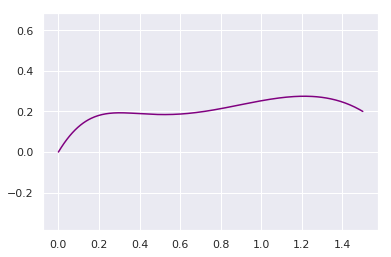

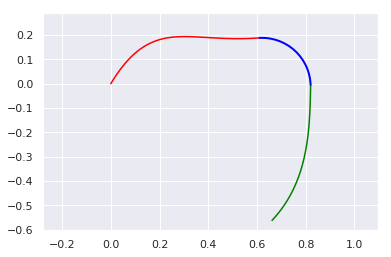

In [10]:
def validateInput(nodes, t1, t2, radius, direction):
    if nodes.shape[1] != 2:
        print('Invalid input: nodes must have exactly 2 columns')
        return False
    elif t1 >= t2:
        print('Invalid input: t1 must be less than t2')
        return False
    elif radius <= 0:
        print('Invalid input: radius must be a positive number')
        return False
    elif not (direction == 1 or direction == -1):
        print('Invalid input: direction must be 1 or -1')
        return False
    else:
        return True

    
def main():
    
    # Declare parameter values
    nodes = np.array([
        [0.0, 0.0],
        [0.3, 0.5],
        [0.5, -0.2],
        [1.0, 0.5],
        [1.5, 0.2]
    ])
    t1 = 0.5
    t2 = 0.7
    radius = 0.2
    direction = -1
    
    # Verify paramters are valid
    if not validateInput(nodes, t1, t2, radius, direction):
        return
    
    # Call the method
    left, arc, right = BendCurve(nodes, t1, t2, radius, direction)
    
    # Plot initial curve
    seaborn.set()
    ax = plt.gca()
    curve = bezier.Curve.from_nodes(nodes.transpose())
    plotBezierCurve(curve, ax, color='purple')
    ax.axis('equal')
    plt.show()

    # Plot the output
    ax = plt.gca()
    plotBezierCurve(left, ax, color='red')
    plotArc(arc, ax, color='blue')
    plotBezierCurve(right, ax, color='green')
    ax.axis('equal')
    plt.show()


if __name__ == '__main__':
    main()